In [1]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# fetch dataset 
website_phishing = fetch_ucirepo(id=379) 
  
# data (as pandas dataframes) 
X = website_phishing.data.features 
y = website_phishing.data.targets 
  
# metadata 
print(website_phishing.metadata) 
  
# variable information 
print(website_phishing.variables) 

# convert target variable to binary
y_binary = np.where(y <= 0, 0, 1)  #  -1 and 0 into class 0, keep 1 as class 1

unique, counts = np.unique(y_binary, return_counts=True)
print("Binary class distribution:")
print(dict(zip(unique, counts)))


{'uci_id': 379, 'name': 'Website Phishing', 'repository_url': 'https://archive.ics.uci.edu/dataset/379/website+phishing', 'data_url': 'https://archive.ics.uci.edu/static/public/379/data.csv', 'abstract': '\n\n', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1353, 'num_features': 9, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Result'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2014, 'last_updated': 'Thu Mar 21 2024', 'dataset_doi': '10.24432/C5B301', 'creators': ['Neda Abdelhamid'], 'intro_paper': {'ID': 440, 'type': 'NATIVE', 'title': 'Phishing detection based Associative Classification data mining', 'authors': 'Neda Abdelhamid, A. Ayesh, F. Thabtah', 'venue': 'Expert systems with applications', 'year': 2014, 'journal': None, 'DOI': '10.1016/j.eswa.2014.03.019', 'URL': 'https://www.semanticscholar.org/paper/867e2293e9780b729705b4ba48d6b1

In [3]:
def preprocess_data(X, y, model_type=None):
    # convert target variable to binary
    y_binary = np.where(y <= 0, 0, 1) 

    # make target y 1D
    y_binary = np.ravel(y_binary)

    # label encoding for target variable
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_binary)

    # feature scaling only for models that benefit 
    if model_type in ['SVM', 'LogisticRegression']:
        scaler = StandardScaler()
        X_processed = scaler.fit_transform(X)
    else:
        # rf doesnt need
        X_processed = X

    return X_processed, y_encoded, label_encoder

In [4]:
classifiers = {
    "SVM": {
        "model": SVC(),
        "param_grid": {
            "C": [10**i for i in range(-7, 4)],  
            "kernel": ["linear", "poly", "rbf"],
            "degree": [2, 3],  
            "gamma": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]  
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(n_estimators=1024),
        "param_grid": {
            "max_features": [1, 2, 4, 6, 8, 12, 16, 20]  
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(),
        "param_grid": {
            "C": [10**i for i in range(-8, 5)],  
            "penalty": ["l2"],  
            "solver": ["lbfgs"] 
        }
    }
}


In [5]:

def evaluate_classifier_with_report(X, y, model, param_grid, partitions, trials, label_encoder):
    results = []
    reports = []

    for trial in range(trials):
        print(f"\n-------- trial {trial + 1} --------")
        for train_size, test_size in partitions:
            #data split according to test and train size
            X_train, X_temp, y_train, y_temp = train_test_split(
                X, y, train_size=train_size, random_state=trial, stratify=y
            )

            X_val, X_test, y_val, y_test = train_test_split(
                X_temp, y_temp, test_size=0.5, random_state=trial, stratify=y_temp
            )

            # preprocess data according to model type
            model_type = model.__class__.__name__
            X_train_processed, y_train_encoded, _ = preprocess_data(X_train, y_train, model_type=model_type)
            X_val_processed, y_val_encoded, _ = preprocess_data(X_val, y_val, model_type=model_type)
            X_test_processed, y_test_encoded, _ = preprocess_data(X_test, y_test, model_type=model_type)

            #tune hyper and evaluate model
            randomized_search = RandomizedSearchCV(model, param_grid, n_iter=min(len(param_grid), 20), cv=3, scoring="accuracy", n_jobs=-1)
            randomized_search.fit(X_train_processed, y_train_encoded)
            best_model = randomized_search.best_estimator_
            cross_val_score_mean = randomized_search.best_score_

            train_acc = accuracy_score(y_train_encoded, best_model.predict(X_train_processed))
            val_acc = accuracy_score(y_val_encoded, best_model.predict(X_val_processed))
            test_preds = best_model.predict(X_test_processed)
            test_acc = accuracy_score(y_test_encoded, test_preds)

            # help w log results
            results.append({
                "trial": trial + 1,
                "partition": (train_size, test_size),
                "train_acc": train_acc,
                "val_acc": val_acc,
                "test_acc": test_acc,
                "cross_val_acc": cross_val_score_mean,
                "best_params": randomized_search.best_params_,
            })

            # make classification report
            report = classification_report(y_test_encoded, test_preds, target_names=label_encoder.classes_, output_dict=True, zero_division=0)
            reports.append({
                "trial": trial + 1,
                "partition": f"{int(train_size*100)}/{int(test_size*100)}",
                "classification_report": report
            })

            print(
                f"partition {int(train_size*100)}/{int(test_size*100)}:"
                f" train acc: {train_acc:.2f}, val acc: {val_acc:.2f}, test acc: {test_acc:.2f}"
            )

    return results, reports


In [6]:
def plot_heatmap(data, title, xlabel, ylabel):
    plt.figure(figsize=(8, 6))
    sns.heatmap(data, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [7]:
def main():
    X_scaled, y_encoded, label_encoder = preprocess_data(X, y, model_type=None)

    partitions = [(0.2, 0.8), (0.5, 0.5), (0.8, 0.2)]
    trials = 3
    all_results = {}
    avg_test_accuracies = {}
    avg_cv_accuracies = {}
    best_hyperparams = {}

    for clf_name, clf_info in classifiers.items():
        print(f"\n-------- {clf_name} --------")
        model = clf_info["model"]
        param_grid = clf_info["param_grid"]
        #code modified to not output reports as it was not needed
        results, reports = evaluate_classifier_with_report(
            X_scaled, y_encoded, model, param_grid, partitions, trials, label_encoder
        )

        # eval and store all results and reports
        result_df = pd.DataFrame(results)
        all_results[clf_name] = result_df

        # calc averages
        avg_test_accuracy = result_df["test_acc"].mean()
        avg_cv_accuracy = result_df["cross_val_acc"].mean()
        avg_test_accuracies[clf_name] = avg_test_accuracy
        avg_cv_accuracies[clf_name] = avg_cv_accuracy

        best_hyperparams[clf_name] = result_df.iloc[0]["best_params"]

        # plot heatmap 
        heatmap_data = result_df.pivot(index="trial", columns="partition", values="test_acc")
        plot_heatmap(
            heatmap_data, f"Test Accuracy Heatmap for {clf_name}", "Partition", "Trial"
        )

    print("\n-------- model summary --------")
    for clf_name in classifiers.keys():
        print(f"\n{clf_name}:")
        print(f"  average test acc: {avg_test_accuracies[clf_name]:.2f}")
        print(f"  average CV acc: {avg_cv_accuracies[clf_name]:.2f}")
        print(f"  best hyperparams: {best_hyperparams[clf_name]}")


-------- SVM --------

-------- trial 1 --------


partition 20/80: train acc: 0.83, val acc: 0.87, test acc: 0.86
partition 50/50: train acc: 0.79, val acc: 0.77, test acc: 0.77
partition 80/20: train acc: 0.97, val acc: 0.90, test acc: 0.89

-------- trial 2 --------
partition 20/80: train acc: 0.87, val acc: 0.83, test acc: 0.85
partition 50/50: train acc: 0.87, val acc: 0.83, test acc: 0.86
partition 80/20: train acc: 0.87, val acc: 0.83, test acc: 0.86

-------- trial 3 --------
partition 20/80: train acc: 0.87, val acc: 0.87, test acc: 0.83
partition 50/50: train acc: 0.88, val acc: 0.87, test acc: 0.87
partition 80/20: train acc: 0.86, val acc: 0.85, test acc: 0.87


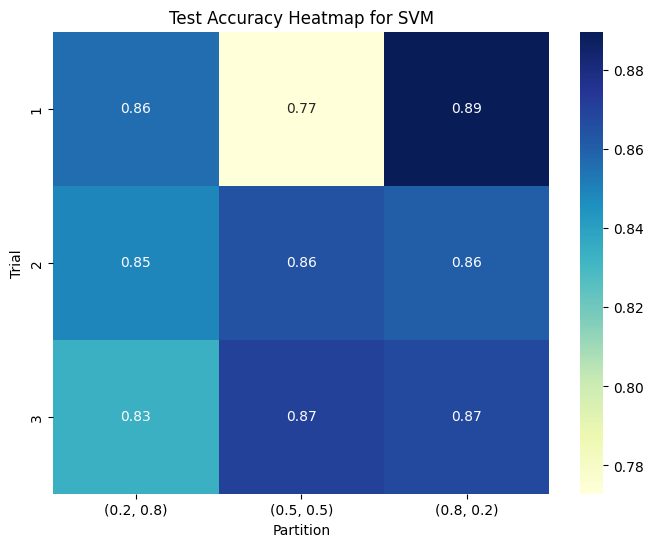


-------- RandomForest --------

-------- trial 1 --------
partition 20/80: train acc: 0.99, val acc: 0.91, test acc: 0.88
partition 50/50: train acc: 0.98, val acc: 0.92, test acc: 0.91
partition 80/20: train acc: 0.97, val acc: 0.90, test acc: 0.91

-------- trial 2 --------
partition 20/80: train acc: 0.99, val acc: 0.90, test acc: 0.88
partition 50/50: train acc: 0.98, val acc: 0.88, test acc: 0.90
partition 80/20: train acc: 0.97, val acc: 0.90, test acc: 0.88

-------- trial 3 --------
partition 20/80: train acc: 0.98, val acc: 0.89, test acc: 0.85
partition 50/50: train acc: 0.97, val acc: 0.88, test acc: 0.88
partition 80/20: train acc: 0.97, val acc: 0.92, test acc: 0.92


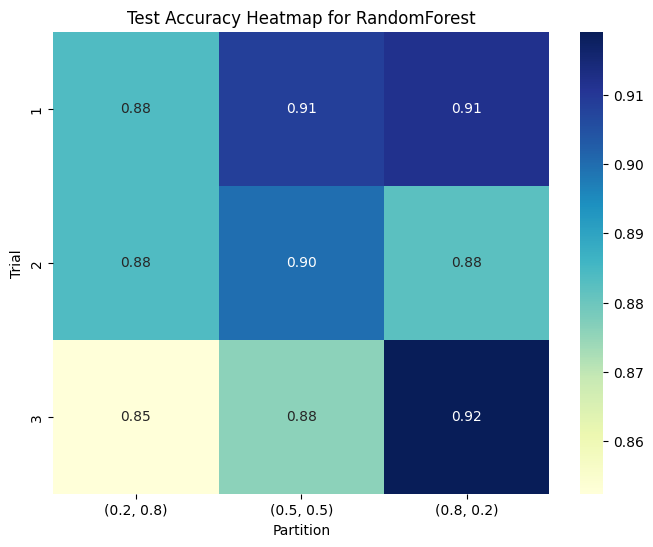


-------- LogisticRegression --------

-------- trial 1 --------
partition 20/80: train acc: 0.83, val acc: 0.89, test acc: 0.86
partition 50/50: train acc: 0.86, val acc: 0.87, test acc: 0.86
partition 80/20: train acc: 0.86, val acc: 0.87, test acc: 0.90

-------- trial 2 --------
partition 20/80: train acc: 0.87, val acc: 0.84, test acc: 0.87
partition 50/50: train acc: 0.87, val acc: 0.84, test acc: 0.87
partition 80/20: train acc: 0.87, val acc: 0.84, test acc: 0.86

-------- trial 3 --------
partition 20/80: train acc: 0.87, val acc: 0.86, test acc: 0.84
partition 50/50: train acc: 0.85, val acc: 0.86, test acc: 0.88
partition 80/20: train acc: 0.87, val acc: 0.84, test acc: 0.88


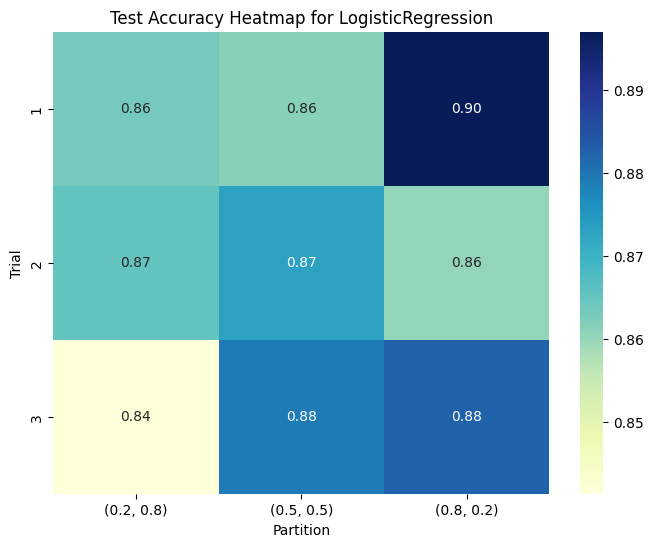


-------- model summary --------

SVM:
  average test acc: 0.85
  average CV acc: 0.85
  best hyperparams: {'kernel': 'linear', 'gamma': 0.5, 'degree': 2, 'C': 10}

RandomForest:
  average test acc: 0.89
  average CV acc: 0.88
  best hyperparams: {'max_features': 1}

LogisticRegression:
  average test acc: 0.87
  average CV acc: 0.86
  best hyperparams: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 10000}


In [8]:
main()